# ML using the web scraped data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from player_data_expansion import get_all_expanded_player_fight_data

In [3]:
# AWS integration getting file data
df_init = pd.read_csv("fight_data.csv").fillna(pd.NA)

In [4]:
df_init.head()

,Date,fighter1,fighter1_result,method_or_round,fighter2,Venue,Undercard fights,link,fighter1_record_wins,fighter1_record_draws,fighter1_record_losses,fighter2_record_wins,fighter2_record_draws,fighter2_record_losses,fighter1_height_cm,fighter2_height_cm,fighter1_ko_percentage,fighter2_ko_percentage,fighter1_debut,fighter2_debut
0,"Saturday, 24 May 2025",Josh Taylor,Loser,"UD, Round 12",Ekow Essuman,"Hydro Arena, Glasgow, United Kingdom",Nathaniel Collins Beat Lee McGregor (TKO 4) \...,https://box.live/fights/taylor-vs-essuman/,19,0,2,21,0,1,178,178.0,68,38,2015,2016
1,"Saturday, 24 May 2025",Angelo Leo,Winner,"MD, Round 12",Tomoki Kameda,"Intex Osaka, Osaka, Japan",Pedro Taduran Beat Ginjiro Shigeoka (SD 12),https://box.live/fights/leo-vs-kameda/,25,0,1,42,0,4,168,170.0,48,55,2012,2008
2,"Friday, 23 May 2025",Rene Calixto,Loser,"SD, Round 12",Willibaldo Garcia,"Gimnasio Marcelino Gonzalez, Zacatecas, Mexico",<NA>,https://box.live/fights/calixto-vs-garcia-ii/,23,1,0,22,2,5,163,163.0,39,59,2016,2017
3,"Friday, 23 May 2025",Terri Harper,Winner,"UD, Round 10",Natalie Zimmermann,"Eco-Power Stadium, Doncaster, United Kingdom",Maxi Hughes Beat Archie Sharp (UD 10),https://box.live/fights/harper-vs-zimmermann/,15,2,2,13,0,0,174,168.0,40,23,2017,2020
4,"Saturday, 17 May 2025",Johnny Fisher,Loser,"TKO, Round 5",Dave Allen,"Copper Box Arena, London, United Kingdom",Kieron Conway Beat Gerome Warburton (TKO 4) \...,https://box.live/fights/fisher-vs-allen-ii/,13,0,0,23,2,7,193,191.0,0,0,2021,2012


In [5]:
df_init.tail(10)

,Date,fighter1,fighter1_result,method_or_round,fighter2,Venue,Undercard fights,link,fighter1_record_wins,fighter1_record_draws,fighter1_record_losses,fighter2_record_wins,fighter2_record_draws,fighter2_record_losses,fighter1_height_cm,fighter2_height_cm,fighter1_ko_percentage,fighter2_ko_percentage,fighter1_debut,fighter2_debut
34,"Friday, 2 May 2025",Ryan Garcia,Loser,"UD, Round 12",Rolando ‘Rolly’ Romero,"Times Square, New York, NY, United States",Devin Haney Beat Jose Ramirez (UD 12) \nTeofi...,https://box.live/fights/garcia-vs-romero/,24,0,1,16,0,2,178,173.0,83,81,2016,2016
35,"Thursday, 1 May 2025",Kevin Lerena,Winner,"TKO, Round 3",Serhiy Radchenko,"Sunbet Arena, Pretoria, South Africa",<NA>,https://box.live/fights/lerena-vs-radchenko/,30,0,3,11,0,7,185,186.0,47,45,2011,2014
36,"Sunday, 27 April 2025",Marlon Tapales,Winner,"RTD, Round 3",Jon Jon Jet,"General Santos City, Cotabato del Sur, Philipp...",<NA>,https://box.live/fights/tapales-vs-jet/,39,0,4,15,1,1,163,166.0,0,0,2008,2015
37,"Saturday, 26 April 2025",Chris Eubank Jr,Winner,"UD, Round 12",Conor Benn,"Tottenham Hotspur Stadium, London, United Kingdom",Anthony Yarde Beat Lyndon Arthur (UD 12) \nAa...,https://box.live/fights/eubank-jr-vs-benn/,34,0,3,23,0,0,180,173.0,74,61,2011,2016
38,"Sunday, 20 April 2025",Ben Whittaker,Winner,"TKO, Round 2",Liam Cameron,"Resorts World Arena, Birmingham, United Kingdom",Sam Eggington Beat Lee Cutler (TD 9) \nFrazer...,https://box.live/fights/whittaker-vs-cameron-ii/,8,1,0,23,1,6,191,183.0,63,43,2022,2009
39,"Saturday, 19 April 2025",Dalton Smith,Winner,"UD, Round 12",Mathieu Germain,"Park Community Arena, Sheffield, United Kingdom",Caoimhin Agyarko Beat Ryan Kelly (MD 10) \nJo...,https://box.live/fights/smith-vs-germain/,17,0,0,26,1,2,176,NaN,0,0,2019,2015
40,"Saturday, 19 April 2025",Gabriela Fundora,Winner,"TKO, Round 7",Marilyn Badillo Amaya,"Frontwave Arena, Oceanside, CA, United States",Jorge Perez Beat Charles Conwell (SD 12) \nOl...,https://box.live/fights/fundora-vs-amaya/,15,0,0,19,1,0,175,160.0,0,0,2021,2017
41,"Saturday, 19 April 2025",Sadriddin Akhmedov,Draw,"MD, Round 10",Elias Espadas,"Commerce Casino, Commerce, CA, United States",<NA>,https://box.live/fights/akhmedov-vs-espadas/,15,0,0,23,0,6,175,178.0,0,0,2018,2012
42,"Friday, 18 April 2025",Sergey Kovalev,Winner,"KO, Round 7",Artur Mann,"Yunost Arena, Chelyabinsk, Russian Federation",<NA>,https://box.live/fights/kovalev-vs-mann/,35,1,5,22,0,4,183,185.0,83,59,2009,2015
43,"Saturday, 10 May 2025",Emanuel Navarrete,Winner,"TD, Round 8",Charly Suarez,"Pechanga Arena, San Diego, CA, United States",Raymond Muratalla Beat Zaur Abdullaev (UD 12)...,https://box.live/fights/navarrete-vs-suarez/,39,1,2,18,0,0,170,168.0,82,56,2012,2019


In [6]:
# ADD BASIC DATA TO SEE IF IT WORKS
df_init = pd.concat([df_init,pd.read_csv("fight_data_backup_basic.csv")], axis=0)
df_init.drop_duplicates(inplace=True)

### start cleaning

In [7]:
df_essentials = df_init.drop(columns=['link','Venue','Date','Undercard fights','fighter1','fighter2'])
df_essentials.head(2)

,fighter1_result,method_or_round,fighter1_record_wins,fighter1_record_draws,fighter1_record_losses,fighter2_record_wins,fighter2_record_draws,fighter2_record_losses,fighter1_height_cm,fighter2_height_cm,fighter1_ko_percentage,fighter2_ko_percentage,fighter1_debut,fighter2_debut
0,Loser,"UD, Round 12",19.0,0.0,2.0,21.0,0.0,1.0,178.0,178.0,68.0,38.0,2015.0,2016.0
1,Winner,"MD, Round 12",25.0,0.0,1.0,42.0,0.0,4.0,168.0,170.0,48.0,55.0,2012.0,2008.0


In [8]:
df_staged_cleaning = df_essentials.copy()
df_staged_cleaning.head(2)

,fighter1_result,method_or_round,fighter1_record_wins,fighter1_record_draws,fighter1_record_losses,fighter2_record_wins,fighter2_record_draws,fighter2_record_losses,fighter1_height_cm,fighter2_height_cm,fighter1_ko_percentage,fighter2_ko_percentage,fighter1_debut,fighter2_debut
0,Loser,"UD, Round 12",19.0,0.0,2.0,21.0,0.0,1.0,178.0,178.0,68.0,38.0,2015.0,2016.0
1,Winner,"MD, Round 12",25.0,0.0,1.0,42.0,0.0,4.0,168.0,170.0,48.0,55.0,2012.0,2008.0


In [9]:
df_staged_cleaning['method_or_round'] = df_staged_cleaning['method_or_round'].str.split(' ')

In [10]:
# last_rounds = [new_list[2] for new_list in df_staged_cleaning['method_or_round']][:]
# df_staged_cleaning['round'] = last_rounds round includes test bias

df_staged_cleaning.head()

,fighter1_result,method_or_round,fighter1_record_wins,fighter1_record_draws,fighter1_record_losses,fighter2_record_wins,fighter2_record_draws,fighter2_record_losses,fighter1_height_cm,fighter2_height_cm,fighter1_ko_percentage,fighter2_ko_percentage,fighter1_debut,fighter2_debut
0,Loser,"[UD,, Round, 12]",19.0,0.0,2.0,21.0,0.0,1.0,178.0,178.0,68.0,38.0,2015.0,2016.0
1,Winner,"[MD,, Round, 12]",25.0,0.0,1.0,42.0,0.0,4.0,168.0,170.0,48.0,55.0,2012.0,2008.0
2,Loser,"[SD,, Round, 12]",23.0,1.0,0.0,22.0,2.0,5.0,163.0,163.0,39.0,59.0,2016.0,2017.0
3,Winner,"[UD,, Round, 10]",15.0,2.0,2.0,13.0,0.0,0.0,174.0,168.0,40.0,23.0,2017.0,2020.0
4,Loser,"[TKO,, Round, 5]",13.0,0.0,0.0,23.0,2.0,7.0,193.0,191.0,0.0,0.0,2021.0,2012.0


In [11]:
df_staged_cleaning = df_staged_cleaning.drop(columns='method_or_round')
df_staged_cleaning.head()

,fighter1_result,fighter1_record_wins,fighter1_record_draws,fighter1_record_losses,fighter2_record_wins,fighter2_record_draws,fighter2_record_losses,fighter1_height_cm,fighter2_height_cm,fighter1_ko_percentage,fighter2_ko_percentage,fighter1_debut,fighter2_debut
0,Loser,19.0,0.0,2.0,21.0,0.0,1.0,178.0,178.0,68.0,38.0,2015.0,2016.0
1,Winner,25.0,0.0,1.0,42.0,0.0,4.0,168.0,170.0,48.0,55.0,2012.0,2008.0
2,Loser,23.0,1.0,0.0,22.0,2.0,5.0,163.0,163.0,39.0,59.0,2016.0,2017.0
3,Winner,15.0,2.0,2.0,13.0,0.0,0.0,174.0,168.0,40.0,23.0,2017.0,2020.0
4,Loser,13.0,0.0,0.0,23.0,2.0,7.0,193.0,191.0,0.0,0.0,2021.0,2012.0


### feature engineering swapped values + add to current values

In [12]:

df_staged_swapping = df_staged_cleaning.copy()

fighter2_wins_temp = df_staged_swapping['fighter2_record_wins'].copy()
fighter2_draws_temp = df_staged_swapping['fighter2_record_draws'].copy()
fighter2_losses_temp = df_staged_swapping['fighter2_record_losses'].copy()
fighter2_height_cm_temp = df_staged_swapping['fighter2_height_cm'].copy()
fighter2_ko_percentage_temp = df_staged_swapping['fighter2_ko_percentage'].copy()
fighter2_debut_temp = df_staged_swapping['fighter2_debut'].copy()

df_staged_swapping['fighter2_record_wins'] = df_staged_swapping['fighter1_record_wins']
df_staged_swapping['fighter2_record_draws'] = df_staged_swapping['fighter1_record_draws']
df_staged_swapping['fighter2_record_losses'] = df_staged_swapping['fighter1_record_losses']
df_staged_swapping['fighter2_height_cm'] = df_staged_swapping['fighter1_height_cm']
df_staged_swapping['fighter2_ko_percentage'] = df_staged_swapping['fighter1_ko_percentage']
df_staged_swapping['fighter2_debut'] = df_staged_swapping['fighter1_debut']

df_staged_swapping['fighter1_record_wins'] = fighter2_wins_temp
df_staged_swapping['fighter1_record_draws'] = fighter2_draws_temp
df_staged_swapping['fighter1_record_losses'] = fighter2_losses_temp
df_staged_swapping['fighter1_height_cm'] = fighter2_height_cm_temp
df_staged_swapping['fighter1_ko_percentage'] = fighter2_ko_percentage_temp
df_staged_swapping['fighter1_debut'] = fighter2_debut_temp



def reverse_results(rowval) : 
    if rowval == 'Winner' :
        return 'Loser'
    elif rowval == 'Loser' :
        return 'Winner'
    else :
        return 'Draw'
    
df_staged_swapping['fighter1_result'] = df_staged_swapping['fighter1_result'].apply(reverse_results)


concatenate the matrices

In [13]:
# df_encoded = pd.concat([df_staged_cleaning, df_staged_swapping], axis=0)
# df_encoded

could also feature engineer the ratio between fighters, such as fighter2/fighter1 for height

### encoding

In [14]:
# this is the original with no swapping
df_encoded = df_staged_cleaning.copy()

In [15]:
# WINNER = 0, LOSER = 1, DRAW = 2
def custom_encoder(value) :
    if value == 'Winner' :
        return 0
    elif value == 'Loser' :
        return 1
    else : return 2
df_encoded['fighter1_result'] = df_encoded['fighter1_result'].apply(custom_encoder)

In [16]:
df_encoded.shape

(49, 13)

In [17]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49 entries, 0 to 11
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   fighter1_result         49 non-null     int64  
 1   fighter1_record_wins    37 non-null     float64
 2   fighter1_record_draws   37 non-null     float64
 3   fighter1_record_losses  37 non-null     float64
 4   fighter2_record_wins    37 non-null     float64
 5   fighter2_record_draws   37 non-null     float64
 6   fighter2_record_losses  37 non-null     float64
 7   fighter1_height_cm      37 non-null     float64
 8   fighter2_height_cm      32 non-null     float64
 9   fighter1_ko_percentage  37 non-null     float64
 10  fighter2_ko_percentage  37 non-null     float64
 11  fighter1_debut          37 non-null     float64
 12  fighter2_debut          37 non-null     float64
dtypes: float64(12), int64(1)
memory usage: 5.4 KB


In [18]:
df_encoded = df_encoded.infer_objects()

df_encoded['fighter1_result'] = df_encoded['fighter1_result'].astype('category')

df_encoded['fighter1_record_wins'] = df_encoded['fighter1_record_wins'].astype('Int64')
df_encoded['fighter1_record_draws'] = df_encoded['fighter1_record_draws'].astype('Int64')
df_encoded['fighter1_record_losses'] = df_encoded['fighter1_record_losses'].astype('Int64')
df_encoded['fighter2_record_wins'] = df_encoded['fighter2_record_wins'].astype('Int64')
df_encoded['fighter2_record_draws'] = df_encoded['fighter2_record_draws'].astype('Int64')
df_encoded['fighter2_record_losses'] = df_encoded['fighter1_record_losses'].astype('Int64')
df_encoded['fighter1_height_cm'] = df_encoded['fighter2_height_cm'].astype('Int64')
df_encoded['fighter2_height_cm'] = df_encoded['fighter2_height_cm'].astype('Int64')
df_encoded['fighter1_ko_percentage'] = df_encoded['fighter1_ko_percentage'].astype('Int64')
df_encoded['fighter2_ko_percentage'] = df_encoded['fighter2_ko_percentage'].astype('Int64')
# df_encoded['round'] = df_encoded['round'].astype('Int64') round includes test bias
df_encoded['fighter1_debut'] = df_encoded['fighter1_debut'].astype('Int64')
df_encoded['fighter2_debut'] = df_encoded['fighter1_debut'].astype('Int64')

In [19]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49 entries, 0 to 11
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   fighter1_result         49 non-null     category
 1   fighter1_record_wins    37 non-null     Int64   
 2   fighter1_record_draws   37 non-null     Int64   
 3   fighter1_record_losses  37 non-null     Int64   
 4   fighter2_record_wins    37 non-null     Int64   
 5   fighter2_record_draws   37 non-null     Int64   
 6   fighter2_record_losses  37 non-null     Int64   
 7   fighter1_height_cm      32 non-null     Int64   
 8   fighter2_height_cm      32 non-null     Int64   
 9   fighter1_ko_percentage  37 non-null     Int64   
 10  fighter2_ko_percentage  37 non-null     Int64   
 11  fighter1_debut          37 non-null     Int64   
 12  fighter2_debut          37 non-null     Int64   
dtypes: Int64(12), category(1)
memory usage: 5.7 KB


In [20]:
df_encoded.describe()

,fighter1_record_wins,fighter1_record_draws,fighter1_record_losses,fighter2_record_wins,fighter2_record_draws,fighter2_record_losses,fighter1_height_cm,fighter2_height_cm,fighter1_ko_percentage,fighter2_ko_percentage,fighter1_debut,fighter2_debut
count,37.0,37.0,37.0,37.0,37.0,37.0,32.0,32.0,37.0,37.0,37.0,37.0
mean,21.297297,0.27027,0.945946,20.486486,0.540541,0.945946,176.21875,176.21875,31.459459,27.0,2015.189189,2015.189189
std,11.575513,0.560191,1.31119,7.467045,0.802586,1.31119,10.400789,10.400789,35.373087,30.962343,5.976053,5.976053
min,1.0,0.0,0.0,0.0,0.0,0.0,160.0,160.0,0.0,0.0,1991.0,1991.0
25%,15.0,0.0,0.0,17.0,0.0,0.0,168.0,168.0,0.0,0.0,2012.0,2012.0
50%,18.0,0.0,0.0,22.0,0.0,0.0,175.0,175.0,0.0,0.0,2017.0,2017.0
75%,26.0,0.0,2.0,23.0,1.0,2.0,183.5,183.5,68.0,56.0,2018.0,2018.0
max,62.0,2.0,5.0,42.0,3.0,5.0,196.0,196.0,96.0,85.0,2024.0,2024.0


### tt split

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X = df_encoded.drop(columns=['fighter1_result', "fighter1_ko_percentage", 'fighter2_ko_percentage'])
y = df_encoded['fighter1_result']
y.unique()

[1, 0, 2]
Categories (3, int64): [0, 1, 2]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=80) # tweak to maker sure that y values contain wins, losses, and draws. ts = .2 and rs =  66
print(y_train.unique())
print(y_test.unique())

[0, 1]
Categories (3, int64): [0, 1, 2]
[0, 2, 1]
Categories (3, int64): [0, 1, 2]


## TRAIN MODEL - XGBoost First

In [24]:
from xgboost import XGBClassifier

In [25]:
xgbc = XGBClassifier(
    objective='multi:softmax',
    random_state=42,
    num_class=3,
    verbosity=1
)

In [26]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [27]:
y_train = encoder.fit_transform(y_train)

In [28]:
# # compute sample weight based on class frequency
# class_weights = dict(enumerate(len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))))
# sample_weight = np.array([class_weights[label] for label in y_train])
# sample_weight

In [29]:
# # no class weighting
xgbc.fit(X_train, y_train)

# class weighting
# xgbc.fit(X_train, y_train, sample_weight=sample_weight)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=3, ...)

In [30]:
xgbc_preds = xgbc.predict(X_test)
xgbc_preds = encoder.inverse_transform(xgbc_preds)

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [32]:
print(accuracy_score(y_test, xgbc_preds))

0.8


In [33]:
print(confusion_matrix(y_test, xgbc_preds))

[[11  0  0]
 [ 1  1  0]
 [ 2  0  0]]


In [34]:
print(classification_report(y_test, xgbc_preds))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        11
           1       1.00      0.50      0.67         2
           2       0.00      0.00      0.00         2

    accuracy                           0.80        15
   macro avg       0.60      0.50      0.52        15
weighted avg       0.71      0.80      0.73        15



c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [35]:
xgbc_preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int64)

### grid search cross validated + XGBoost Classifier - same rseult as initial one

In [36]:
from sklearn.model_selection import GridSearchCV

In [37]:
eval_set = [(X, y)] # validation set for early stopping

In [38]:
xgbc_model2 = XGBClassifier(
    objective='multi:softmax',
    random_state=42,
    num_class=3,
    verbosity=1,
    eval_metric="mlogloss"
)

In [39]:
param_grid = {
    "subsample":[0.75, 1],
     "colsample_bytree":[0.75, 1],
     "max_depth":[2, 6],
     "min_child_weight":[1, 2,3],
     "learning_rate":[1, 0.1, 0.01],
}

In [40]:
xgbc_grid = GridSearchCV(
    xgbc_model2,
    param_grid,
    cv=3,
    scoring="f1"
)

In [41]:
# xgbc_grid.fit(X_train,y_train,eval_set=eval_set,verbose=1)

In [42]:
# xgbc_grid.best_params_

In [43]:
# xgbc_cv_best = XGBClassifier(
#     colsample_bytree = 0.75,
#     learning_rate = 1,
#     max_depth = 2,
#     min_child_weight = 1,
#     subsample = 0.75,
#     objective='multi:softmax',
#     random_state=42,
#     num_class=3,
#     verbosity=1,
#     eval_metric="mlogloss"
# )

In [44]:
# xgbc_cv_best.fit(X_train,y_train)

In [45]:
# xgbc_cv_best_preds = xgbc_cv_best.predict(X_test)
# xgbc_cv_best_preds = encoder.inverse_transform(xgbc_cv_best_preds)

In [46]:
# print(confusion_matrix(y_test, xgbc_cv_best_preds),"\n")
# print(classification_report(y_test, xgbc_cv_best_preds))

### random forest

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
X_train.shape[1]

10

In [49]:
rfc_1 = RandomForestClassifier(
    n_estimators=round(np.sqrt(X_train.shape[1])),
    random_state=42
    )

In [50]:
rfc_1.fit(X_train,y_train)

RandomForestClassifier(n_estimators=3, random_state=42)

In [51]:
rfc_1_preds = rfc_1.predict(X_test)

In [52]:
rfc_1_preds = encoder.inverse_transform(rfc_1_preds)

In [53]:
print(classification_report(y_test,rfc_1_preds))
print(confusion_matrix(y_test,rfc_1_preds))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        11
           1       1.00      0.50      0.67         2
           2       0.00      0.00      0.00         2

    accuracy                           0.80        15
   macro avg       0.60      0.50      0.52        15
weighted avg       0.71      0.80      0.73        15

[[11  0  0]
 [ 1  1  0]
 [ 2  0  0]]


c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### PCA

In [54]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# create the zero NA dataframe to be used
df_encoded_no_na = df_encoded.dropna()

# create X values df
X_pca = df_encoded_no_na.drop(columns='fighter1_result')

# create scaler, scale values based on std dev = 1
scaler = StandardScaler()
scaler.fit(df_encoded_no_na) # fitting the scaler
scaled_data = scaler.transform(df_encoded_no_na) # transform values based on scaling model

# create, fit PCA and transform the data based on fit to reduce dimensionality
pca = PCA()
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

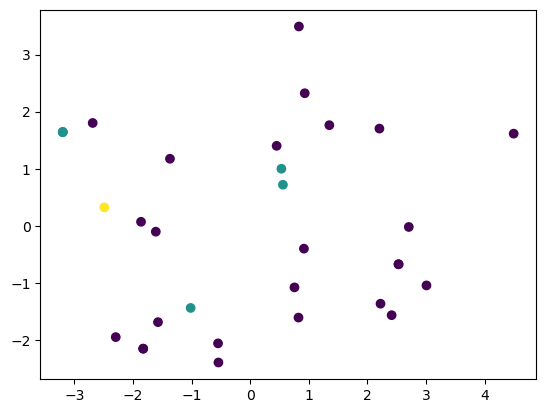

In [55]:
plt.scatter(x_pca[:,0], x_pca[:,1], c=df_encoded_no_na['fighter1_result'])

### Neural Network: Deep Learning with Keras & Tensorflow??
lots of NA values - must impute somehow

In [56]:
X_train_tf = X_train.copy()
y_train_tf = y_train.copy()

X_test_tf = X_test.copy()
y_test_tf = y_test.copy()

In [57]:
from sklearn.preprocessing import MinMaxScaler

In [58]:
mm_scaler = MinMaxScaler()

In [59]:
X_train_tf = mm_scaler.fit_transform(X_train_tf)

In [60]:
X_test_tf = mm_scaler.transform(X_test_tf)

### fit the Neural Network Model

In [61]:
from tensorflow.keras.callbacks import EarlyStopping

In [62]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [64]:
X_train.shape

(34, 10)

In [65]:
tensor_model = Sequential()

tensor_model.add(Dense(27, activation='relu'))
tensor_model.add(Dropout(0.5))

tensor_model.add(Dense(14, activation='relu'))
tensor_model.add(Dropout(0.5))

tensor_model.add(Dense(7, activation='relu'))
tensor_model.add(Dropout(0.5))

tensor_model.add(Dense(1, activation='sigmoid'))
tensor_model.add(Dropout(0.5))

tensor_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

**NEED TO IMPUTE NA VALUES FOR TENSORFLOW TO WORK PROPERLY**

In [66]:
# tensor_model.fit(X_train, y_train, epochs=500, validation_data=(X_test, y_test), callbacks=[early_stop])